In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


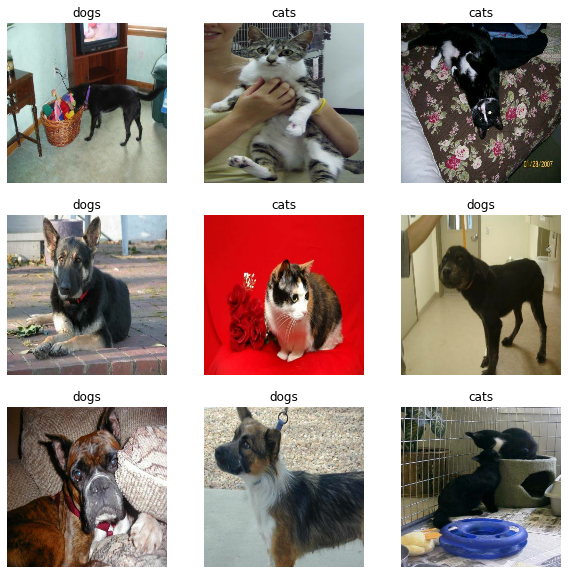

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

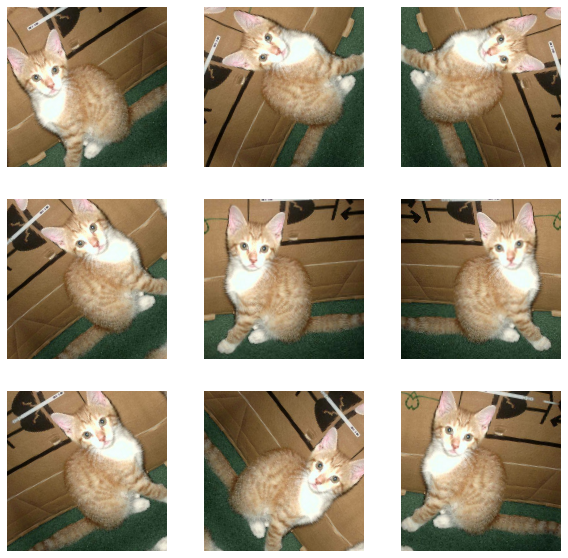

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# alternative way for preprocessing
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
########################################################
x = base_model(x, training=False) # training = False cause BN layer not to be trained again
########################################################
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 15s 473ms/step - loss: 0.8104 - accuracy: 0.4938


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 58s 871ms/step - loss: 0.7418 - accuracy: 0.5545 - val_loss: 0.5471 - val_accuracy: 0.6658
Epoch 2/10
63/63 [==============================] - 50s 786ms/step - loss: 0.5632 - accuracy: 0.6790 - val_loss: 0.3928 - val_accuracy: 0.8007
Epoch 3/10
63/63 [==============================] - 49s 775ms/step - loss: 0.4453 - accuracy: 0.7675 - val_loss: 0.3077 - val_accuracy: 0.8626
Epoch 4/10
63/63 [==============================] - 49s 773ms/step - loss: 0.3685 - accuracy: 0.8100 - val_loss: 0.2500 - val_accuracy: 0.8936
Epoch 5/10
63/63 [==============================] - 49s 770ms/step - loss: 0.3155 - accuracy: 0.8485 - val_loss: 0.2147 - val_accuracy: 0.9121
Epoch 6/10
63/63 [==============================] - 49s 768ms/step - loss: 0.2837 - accuracy: 0.8770 - val_loss: 0.1861 - val_accuracy: 0.9220
Epoch 7/10
63/63 [==============================] - 49s 778ms/step - loss: 0.2657 - accuracy: 0.8820 - val_loss: 0.1726 - val_accuracy: 0.9282

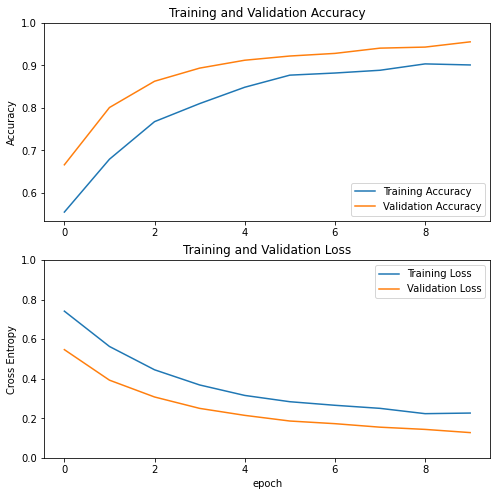

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 81s 1s/step - loss: 0.1661 - accuracy: 0.9265 - val_loss: 0.0619 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 75s 1s/step - loss: 0.1215 - accuracy: 0.9545 - val_loss: 0.0551 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 77s 1s/step - loss: 0.1043 - accuracy: 0.9615 - val_loss: 0.0475 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 77s 1s/step - loss: 0.0902 - accuracy: 0.9615 - val_loss: 0.0511 - val_accuracy: 0.9752
Epoch 14/20
63/63 [==============================] - 77s 1s/step - loss: 0.0885 - accuracy: 0.9640 - val_loss: 0.0419 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 76s 1s/step - loss: 0.0737 - accuracy: 0.9690 - val_loss: 0.0374 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 77s 1s/step - loss: 0.0783 - accuracy: 0.9710 - val_loss: 0.0369 - val_accuracy: 0.9851
Epoch 17/20
6

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

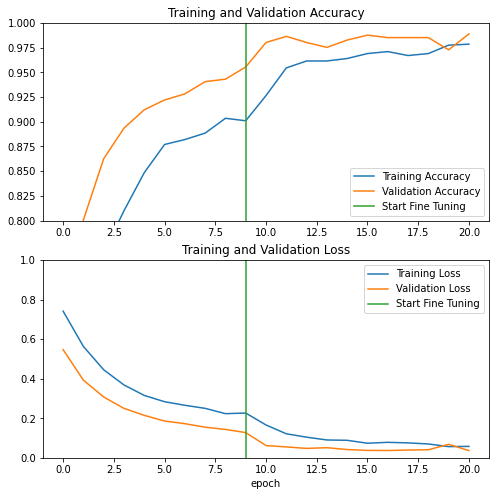

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 530ms/step - loss: 0.0287 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions:
 [0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1]
Labels:
 [0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1]


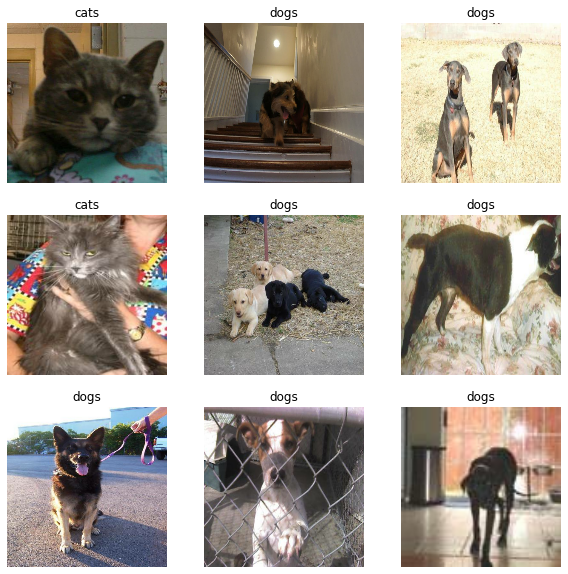

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=['accuracy'])

fine_tune_epochs_2 = 10
total_epochs_2 =  initial_epochs + fine_tune_epochs + fine_tune_epochs_2

history_fine_2 = model.fit(train_dataset,
                         epochs=total_epochs_2,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/30
63/63 [==============================] - 87s 1s/step - loss: 0.0576 - accuracy: 0.9765 - val_loss: 0.0382 - val_accuracy: 0.9864
Epoch 21/30
63/63 [==============================] - 77s 1s/step - loss: 0.0599 - accuracy: 0.9785 - val_loss: 0.0351 - val_accuracy: 0.9864
Epoch 22/30
63/63 [==============================] - 76s 1s/step - loss: 0.0484 - accuracy: 0.9805 - val_loss: 0.0401 - val_accuracy: 0.9864
Epoch 23/30
63/63 [==============================] - 76s 1s/step - loss: 0.0446 - accuracy: 0.9845 - val_loss: 0.0377 - val_accuracy: 0.9851
Epoch 24/30
63/63 [==============================] - 75s 1s/step - loss: 0.0437 - accuracy: 0.9835 - val_loss: 0.0400 - val_accuracy: 0.9851
Epoch 25/30
63/63 [==============================] - 75s 1s/step - loss: 0.0447 - accuracy: 0.9780 - val_loss: 0.0392 - val_accuracy: 0.9864
Epoch 26/30
63/63 [==============================] - 76s 1s/step - loss: 0.0408 - accuracy: 0.9810 - val_loss: 0.0316 - val_accuracy: 0.9876
Epoch 27/30
6

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/1000),
              metrics=['accuracy'])

fine_tune_epochs_3 = 10
total_epochs_3 =  initial_epochs + fine_tune_epochs + fine_tune_epochs_2 + fine_tune_epochs_3

history_fine_3 = model.fit(train_dataset,
                         epochs=total_epochs_3,
                         initial_epoch=history_fine_2.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/40
63/63 [==============================] - 82s 1s/step - loss: 0.0452 - accuracy: 0.9810 - val_loss: 0.0387 - val_accuracy: 0.9851
Epoch 31/40
63/63 [==============================] - 74s 1s/step - loss: 0.0464 - accuracy: 0.9840 - val_loss: 0.0378 - val_accuracy: 0.9839
Epoch 32/40
63/63 [==============================] - 76s 1s/step - loss: 0.0407 - accuracy: 0.9820 - val_loss: 0.0362 - val_accuracy: 0.9851
Epoch 33/40
63/63 [==============================] - 75s 1s/step - loss: 0.0502 - accuracy: 0.9770 - val_loss: 0.0373 - val_accuracy: 0.9839
Epoch 34/40
63/63 [==============================] - 75s 1s/step - loss: 0.0434 - accuracy: 0.9835 - val_loss: 0.0383 - val_accuracy: 0.9864
Epoch 35/40
63/63 [==============================] - 74s 1s/step - loss: 0.0453 - accuracy: 0.9865 - val_loss: 0.0386 - val_accuracy: 0.9864
Epoch 36/40
63/63 [==============================] - 75s 1s/step - loss: 0.0402 - accuracy: 0.9840 - val_loss: 0.0387 - val_accuracy: 0.9864
Epoch 37/40
6

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 507ms/step - loss: 0.0129 - accuracy: 0.9948
Test accuracy : 0.9947916865348816
